<a href="https://colab.research.google.com/github/FleaBusyBeeBergs/dtsa5506-pipeline/blob/main/dtsa5506_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-learn-intelex -q
!pip install statsmodels==0.14.0 -q
!pip install tslearn -q
!pip install scikeras -q
!pip install xgboost lightgbm catboost imbalanced-learn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.4/91.4 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.6 MB/s eta 0:00:00


In [2]:
# file handling & general
import itertools
import numpy as np
import pandas as pd
import os
from google.colab import files
import xml.etree.ElementTree as ET
import warnings
warnings.filterwarnings('ignore',
                        message = '''.*'force_all_finite' was renamed to 'ensure_all_finite'.*''')
from google.colab import files

# http requests
import requests

# vis
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import altair as alt
import seaborn as sns

# eda
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import pointbiserialr

# pca
from sklearn.decomposition import PCA
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.cluster import DBSCAN

# preprocessing & ml
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
# from sklearn.impute import SimpleImputer
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
# from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, silhouette_score

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor

# clustering
from tslearn.clustering import TimeSeriesKMeans
from tslearn import metrics

Intel(R) Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


## Introduction

The main idea of this project is to predict interest rate changes before they are announced. Interest rates affect nearly everyone and changes to the prevailing rates affect many decisions not just in the long term, but in the short term as well.

The bank of canada exercises counter-inflationary monetary policy by increasing interest to slow inflation, and decreasing interest to allow to avoid recession. To predict changes to the policy interest rate, it would be helpful to first model and predict inflation. The consumer price index is a common measure of inflation, and cpi time series is available from statistics canada.

 Thinking back to when I studied economics as an undergrad, I remember the 2 drivers of inflation being cost-push and demand-pull. In this project I will focus on the cost-push side of things. Intuitively, I think of the inputs to producing goods and services as being materials and wages. For a simple model, the 2 indicators I will use from statistics canada to model cpi are the raw materials price index and average weekly wages.

 Once I have a forcast of cpi, I will use that to make predictions on whether the bank of canada will decrease, hold steady, or increase interest rates. Note to readers: I've kept the language of this notebook on the casual side. For a (slightly) more formal report, see dtsa5506_final_project_report.pdf in repository.

## Extract, Transform, Load (ETL) pipeline

Statistics Canada has a data cube available to the public, and provides instructions to make http requests [1]. I used these these instructions to request very specific information for specific dates, rather than having to download entire tables. I was able to write code for a single vector request, then spent a lot of time trying to write my own functions before turning to a code generator [2] for the following StatCanETL class.

In [3]:
# base URL for data extraction
base_url = 'https://www150.statcan.gc.ca/t1/wds/sdmx/statcan/rest/vector/'

# namespace mappings for XML parsing
namespaces = {
    "message": 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/message',
    "generic": 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/data/generic',
    "common": 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/common',
}


In [4]:
class StatCanETL:
    '''ETL pipeline for StatCan data'''

    def __init__(self, table_df):
        '''initialize with df of metadata table'''
        self.table_df = table_df
        self.data_objects = {}

    def extract(self, vector, start_period, end_period):
        '''extract data from the StatCan API for a given vector, start, and end dates'''
        url = f'{base_url}{vector}?startPeriod={start_period}&endPeriod={end_period}&detail=full'
        response = requests.get(url)

        if response.status_code == 200:
            return response.content
        else:
            raise ValueError(f'Failed to fetch data for vector {vector}. HTTP Status: {response.status_code}')

    def transform(self, xml_content, frequency):
        '''transform the XML response into a structured DataFrame.'''
        # parse XML content
        root = ET.fromstring(xml_content)

        # locate the series element
        series = root.find('.//generic:Series', namespaces)
        if series is None:
            raise ValueError('No Series element found in the XML response')

        # extract obs
        observations = series.findall('.//generic:Obs', namespaces)
        data = []
        for obs in observations:
            obs_dim = obs.find('.//generic:ObsDimension', namespaces)
            obs_val = obs.find('.//generic:ObsValue', namespaces)
            date = obs_dim.attrib['value']

            # convert date format if quarterly or yearly
            if frequency == 'quarterly':
                date = self.convert_quarter_to_date(date)
            elif frequency == 'yearly':
                date = date[:4] + '-01'

            data.append({
                'Date': date,
                'Value': float(obs_val.attrib['value']),
            })

        # convert to df
        df = pd.DataFrame(data)
        return df

    @staticmethod
    def convert_quarter_to_date(quarter_str):
        '''convert quarterly date string (YYYY-Qx) to a standard date format (YYYY-MM)'''
        try:
            year, quarter = quarter_str.split('-Q')
            quarter_start_month = {
                '1': '01',
                '2': '04',
                '3': '07',
                '4': '10',
            }.get(quarter)
            if quarter_start_month:
                return f'{year}-{quarter_start_month}'
            else:
                raise ValueError(f'Invalid quarter format: {quarter_str}')
        except Exception as e:
            raise ValueError(f'Error converting quarter string {quarter_str}: {e}')

    def load(self, df, name):
        '''load df into object named name_df.'''
        variable_name = f'{name}_df'
        globals()[variable_name] = df
        self.data_objects[variable_name] = df
        print(f'Data for {name} saved to object {variable_name}')

    def run(self):
        '''Run the full ETL pipeline for all variables'''
        for _, row in self.table_df.iterrows():
            print(f'Processing {row["name"]}...')
            try:
                # extract
                xml_content = self.extract(row['vector'], row['start'], row['end'])

                # transform
                df = self.transform(xml_content, row['frequency'])

                # load
                self.load(df, row['name'])
            except Exception as e:
                print(f'Error processing {row["name"]}: {e}')

In [5]:
# metadata - define what information to pull from statcan
tables = {
    'name': ['wage', 'rmpi', 'cpi', 'rate'],
    'tableid': [14100223, 18100268, 18100004, 10100139],
    'tablename': ['employment and average weekly earnings',
                  'raw materials price index, 2010 = 100',
                  'consumer price index, not seasonally adjusted, 2002 = 100', 'bank rate'],
    'vector': ['v79311153', 'v1230998135', 'v41690973', 'v39078'],
    'vectdesc': ['', '', '', ''],
    'description': ['', '', '', ''],
    'frequency': ['monthly', 'monthly', 'monthly', 'daily'],
    'start': ['2001-01', '2001-01', '2001-01', '2001-01-01'], # if using quarterly data like productivity, format as yyyy-Q#
    'end': ['2024-12', '2024-12', '2024-12', '2024-12-31']
}

# make df
table_df = pd.DataFrame(tables)

In [6]:
# run ETL pipe
pipeline = StatCanETL(table_df)
pipeline.run()

Processing wage...
Data for wage saved to object wage_df
Processing rmpi...
Data for rmpi saved to object rmpi_df
Processing cpi...
Data for cpi saved to object cpi_df
Processing rate...
Data for rate saved to object rate_df


In [7]:
# save to csv
# wage_df.to_csv('wage.csv', index=False)
# rmpi_df.to_csv('rmpi.csv', index=False)
# cpi_df.to_csv('cpi.csv', index=False)
# rate_df.to_csv('rate.csv', index=False)

# download for working offline, saved to data folder of repo
# files.download('wage.csv')
# files.download('rmpi.csv')
# files.download('cpi.csv')
# files.download('rate.csv')

#### Rate announcement dates

I looked through Bank of Canada publications to find the following rate annoucement dates. I added them to a .csv in the data folder of my repo.

In [8]:
# rate announcement dates
url = 'https://raw.githubusercontent.com/FleaBusyBeeBergs/dtsa5506-pipeline/main/data/rate-announcements.csv'
#url = None
rate_announcements = pd.read_csv(url)
rate_announcements.head(8)

,date
0,2001-01-23
1,2001-03-06
2,2001-04-17
3,2001-05-29
4,2001-07-17
5,2001-08-28
6,2001-10-23
7,2001-11-27


## EDA and cleaning

In [9]:
# check to see if data loaded correctly
for key, value in pipeline.data_objects.items():
    print(key)
    print(value.head(3), '\n')

wage_df
      Date   Value
0  2001-01  657.14
1  2001-02  653.59
2  2001-03  655.14 

rmpi_df
      Date  Value
0  2001-01   65.2
1  2001-02   65.8
2  2001-03   65.5 

cpi_df
      Date  Value
0  2001-01   96.3
1  2001-02   96.8
2  2001-03   97.1 

rate_df
         Date  Value
0  2001-01-01    6.0
1  2001-01-02    6.0
2  2001-01-03    6.0 



In [10]:
# rename columns
wage_df.rename(columns = {'Value': 'wage',
                          'Date': 'date'},
               inplace = True)
rmpi_df.rename(columns = {'Value': 'rmpi',
                          'Date': 'date'},
               inplace = True)
cpi_df.rename(columns={'Value': 'cpi',
                       'Date': 'date'},
               inplace = True)
rate_df.rename(columns={'Value': 'rate',
                        'Date': 'date'},
               inplace = True)

In [11]:
# merge tables with monthly data
data = wage_df.merge(rmpi_df,
                     on = 'date',
                     how = 'outer')\
              .merge(cpi_df,
                     on = 'date',
                     how = 'outer')

In [12]:
print(data)
print(data.info())

        date     wage   rmpi    cpi
0    2001-01   657.14   65.2   96.3
1    2001-02   653.59   65.8   96.8
2    2001-03   655.14   65.5   97.1
3    2001-04   652.44   65.2   97.8
4    2001-05   652.28   65.3   98.6
..       ...      ...    ...    ...
283  2024-08  1274.25  139.3  161.8
284  2024-09  1277.70  134.8  161.1
285  2024-10  1284.24  140.3  161.8
286  2024-11  1285.61  140.2  161.8
287  2024-12  1290.82  142.0  161.2

[288 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    288 non-null    object 
 1   wage    288 non-null    float64
 2   rmpi    288 non-null    float64
 3   cpi     288 non-null    float64
dtypes: float64(3), object(1)
memory usage: 9.1+ KB
None


At the time of writing, wage was missing one observation from 2024-12.
I assume this is because it may take a while for the data to be processed each month. I'll use forward fill to deal with that missing value. If quarterly data was pulled from the data cube, there would be missing data for the months 02-03, 05-06, 08-09, and 11-12. Forward fill could also deal with those missing observations.

In [13]:
# fill na
data = data.ffill()

In [14]:
# format date
data['date'] = pd.to_datetime(data['date']).dt.strftime('%Y-%m')

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    288 non-null    object 
 1   wage    288 non-null    float64
 2   rmpi    288 non-null    float64
 3   cpi     288 non-null    float64
dtypes: float64(3), object(1)
memory usage: 9.1+ KB


In [16]:
# descriptive stats
data.describe()

,wage,rmpi,cpi
count,288.000000,288.000000,288.000000
mean,911.647257,99.128125,123.738542
std,170.133565,24.307042,17.143681
min,652.280000,55.300000,96.300000
25%,772.157500,84.075000,109.775000
50%,903.520000,97.050000,122.200000
75%,1009.597500,112.725000,134.225000
max,1290.820000,166.600000,162.100000


The interest rate data is published (almost) daily, but only changes at 8 pre-determined dates per year. This will require some extra wrangling to align with the other monthly series. Where there is a rate change, I'll apply changed rate to that entire month, effective on the 1st day, so that rate_df can be aligned with the rate announcement data.

In [17]:
print(rate_df.info())
print(rate_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8766 entries, 0 to 8765
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    8766 non-null   object 
 1   rate    6231 non-null   float64
dtypes: float64(1), object(1)
memory usage: 137.1+ KB
None
              rate
count  6231.000000
mean      2.237963
std       1.519686
min       0.500000
25%       1.000000
50%       1.750000
75%       3.250000
max       6.000000


In [18]:
# date format
rate_df['date'] = pd.to_datetime(rate_df['date'])

# continuous dates
rate_df = rate_df.set_index('date')\
                           .asfreq('D')\
                           .reset_index()

# fill na
rate_df['rate'] = rate_df['rate'].ffill()

In [19]:
rate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8766 entries, 0 to 8765
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    8766 non-null   datetime64[ns]
 1   rate    8766 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 137.1 KB


In [20]:
def preprocess_rate(rate_df):
    """
    Cleans and transforms daily interest rate DataFrame to monthly,
    applying the new rate to the first day of the month of change.

    Args:
        rate_df (pd.DataFrame): DataFrame containing 'date' and 'rate' columns.

    Returns:
        pd.DataFrame: DataFrame with monthly interest rates.
    """

    # sort
    rate_df = rate_df.sort_values('date')

    # rate changes
    rate_df['prev_rate'] = rate_df['rate'].shift(1)
    rate_df['rate_changed'] = rate_df['rate'] != rate_df['prev_rate']

    # filter changes
    rate_changes = rate_df[rate_df['rate_changed']].copy()

    # rate effective first of month
    rate_changes['date'] = rate_changes['date'].dt.to_period('M')\
                                               .dt.to_timestamp()

    # ensure unique dates
    rate_changes = rate_changes.groupby('date')['rate']\
                               .last()\
                               .reset_index()


    # drop unnecessary cols
    rate_changes = rate_changes[['date', 'rate']]

    # monthly frequency fwd fill
    monthly_rate_df = rate_changes.set_index('date')\
                                  .resample('MS')\
                                  .ffill()\
                                  .reset_index()

    # format date
    monthly_rate_df['date'] = monthly_rate_df['date'].dt.strftime('%Y-%m')

    return monthly_rate_df

In [21]:
# preprocess rate_df
rate_df = preprocess_rate(rate_df)

In [22]:
rate_df.head()

,date,rate
0,2001-01,5.75
1,2001-02,5.75
2,2001-03,5.25
3,2001-04,5.00
4,2001-05,4.75


In [23]:
rate_announcements.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    201 non-null    object
dtypes: object(1)
memory usage: 1.7+ KB


In [24]:
rate_announcements.head()

,date
0,2001-01-23
1,2001-03-06
2,2001-04-17
3,2001-05-29
4,2001-07-17


In [25]:
def preprocess_rate_announcements(rate_announcements):
    '''
    preprocesses rate announcement data by setting the effective date to the
    first day of the announcement month.

    args:
        rate_announcements (pd.DataFrame): DataFrame containing rate announcements
            with a 'date' column as the index.

    returns:
        pd.DataFrame: Preprocessed DataFrame with 'date' as the index, representing
            the first day of the announcement month, and an 'announcement' column.
    '''

    # reset index if needed
    if rate_announcements.index.name == 'date':
        rate_announcements = rate_announcements.reset_index()

    # date dtype
    rate_announcements['date'] = pd.to_datetime(rate_announcements['date'])

    # date format
    rate_announcements['date'] = rate_announcements['date'].dt.strftime('%Y-%m')

    # announcement column of 1s
    rate_announcements['announcement'] = 1

    # drop duplicates)
    rate_announcements = rate_announcements.drop_duplicates(subset='date')

    # date as index
    rate_announcements = rate_announcements.set_index('date')

    return rate_announcements


In [26]:
rate_announcements = preprocess_rate_announcements(rate_announcements)
rate_announcements.head()

,announcement
date,
2001-01,1
2001-03,1
2001-04,1
2001-05,1
2001-07,1


In [27]:
data = data.merge(rate_df,
                  on = 'date',
                  how = 'outer')\
           .merge(rate_announcements,
                  on = 'date',
                  how = 'outer')\
           .set_index('date')

In [28]:
# no announcement = 0
data['announcement'] = data['announcement'].fillna(0)

In [29]:
data.head()

,wage,rmpi,cpi,rate,announcement
date,,,,,
2001-01,657.14,65.2,96.3,5.75,1.0
2001-02,653.59,65.8,96.8,5.75,0.0
2001-03,655.14,65.5,97.1,5.25,1.0
2001-04,652.44,65.2,97.8,5.00,1.0
2001-05,652.28,65.3,98.6,4.75,1.0


#### Scaling the data

Comparing series with different magnitudes can be a bit like comparing apples to oranges, or maybe grapes to watermelons. Scaling the data makes visually comparing the series easier and is also required for some ml models.

In [30]:
scaler = MinMaxScaler
data_scaled = data.copy()
data_scaled[['wage', 'rmpi', 'cpi', 'rate']] = scaler().fit_transform(data[['wage', 'rmpi', 'cpi', 'rate']])
data_scaled.describe()

,wage,rmpi,cpi,rate,announcement
count,288.000000,288.000000,288.000000,288.000000,296.000000
mean,0.406188,0.393784,0.416999,0.331845,0.675676
std,0.266442,0.218392,0.260542,0.290006,0.468915
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.187737,0.258535,0.204787,0.095238,0.000000
50%,0.393460,0.375112,0.393617,0.238095,1.000000
75%,0.559585,0.515948,0.576368,0.523810,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


Let's have a look at what the plotted data looks like.

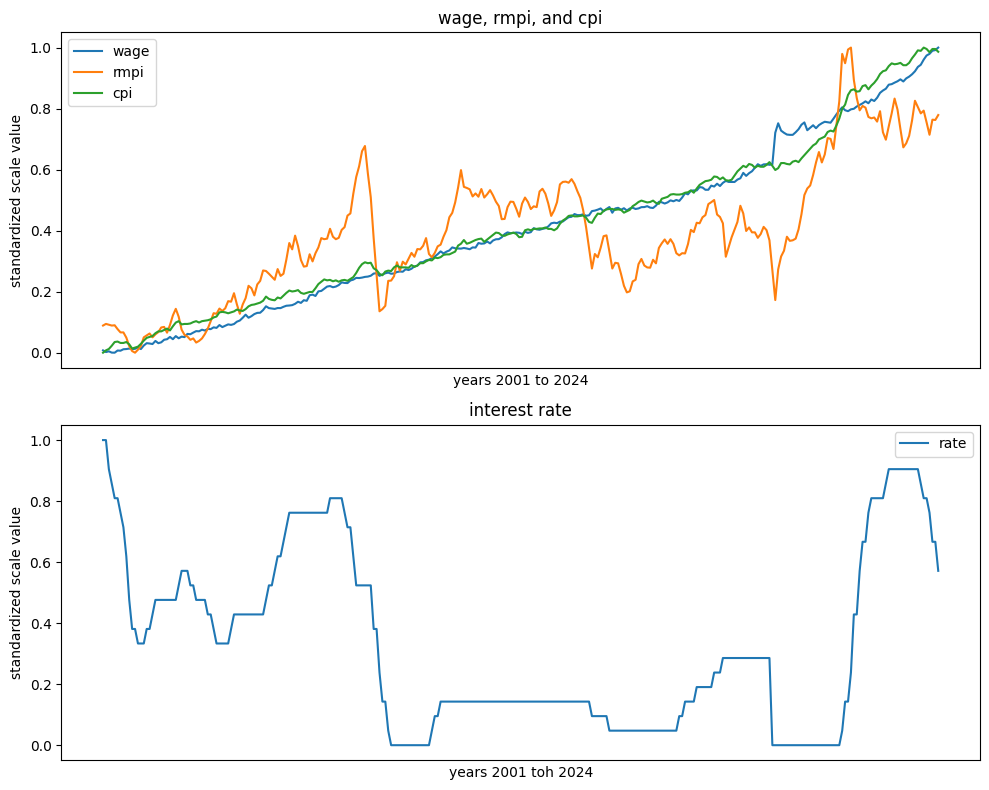

In [31]:
fig, axes = plt.subplots(2, 1,
                         figsize = (10, 8),
                         sharex = True)

# separate plot
second = ['rate', 'announcement']

for col in data_scaled.columns:
    if col not in second:
        axes[0].plot(data_scaled.index,
                     data_scaled[col],
                     linestyle = '-',
                     label = col)

axes[0].set_xlabel('years 2001 to 2024')
axes[0].set_ylabel('standardized scale value')
axes[0].set_title('wage, rmpi, and cpi')
axes[0].legend()
axes[0].set_xticks([])

# separate plot
for col in data_scaled.columns:
    if col == 'rate':
        axes[1].plot(data_scaled.index,
                     data_scaled[col],
                     linestyle = '-',
                     label = col)

axes[1].set_xlabel('years 2001 toh 2024')  # Set x-axis label for second subplot
axes[1].set_ylabel('standardized scale value')
axes[1].set_title('interest rate')
axes[1].legend()
axes[0].set_xticks([])

plt.tight_layout()
plt.show()

In the first figure above, we can see that wage appears to be closely correlated with the cpi with a nearly-constant upward linear trend. rmpi is relatively more volatile but appears to also follow an upward trend.

### Transforming data with differencing

In order to create an arima model to further understand the cpi data, we need to make sure the data is stationary. An ADF stationarity test will be used to test for this.


In [32]:
data_diff = data.copy().dropna()

In [33]:
data_diff.info()

<class 'pandas.core.frame.DataFrame'>
Index: 288 entries, 2001-01 to 2024-12
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   wage          288 non-null    float64
 1   rmpi          288 non-null    float64
 2   cpi           288 non-null    float64
 3   rate          288 non-null    float64
 4   announcement  288 non-null    float64
dtypes: float64(5)
memory usage: 13.5+ KB


In [34]:
# adf test for stationarity
adf_result = adfuller(data_diff['cpi'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: 0.7257562584956001
p-value: 0.990338109629542


Given the p-value of 0.99, we can see that the cpi data is not currently stationary. Differencing will be needed to address this.

There a few different types of differencing, two of which are standard first-order differencing and HP filtering. Standard first-order differencing finds the difference between each oberservation and the previous observation, while HP filtering breaks down a time series into it's cyclical and trend components.

In [35]:
# hp filter differencing
lambda_value = 10
cycle, trend = hpfilter(data_diff['cpi'], lamb = lambda_value)
data_diff['cpi_cyclical'] = data_diff['cpi'] - trend
data_diff['cpi_trend'] = trend

In [36]:
# standard first order differencing
data_diff['cpi_diff'] = data_diff['cpi'].diff()
data_diff.dropna(inplace = True)

In [37]:
data_diff.head()

,wage,rmpi,cpi,rate,announcement,cpi_cyclical,cpi_trend,cpi_diff
date,,,,,,,,
2001-02,653.59,65.8,96.8,5.75,0.0,-0.109655,96.909655,0.5
2001-03,655.14,65.5,97.1,5.25,1.0,-0.273467,97.373467,0.3
2001-04,652.44,65.2,97.8,5.00,1.0,0.000203,97.799797,0.7
2001-05,652.28,65.3,98.6,4.75,1.0,0.462926,98.137074,0.8
2001-06,656.81,63.9,98.7,4.75,0.0,0.366252,98.333748,0.1


In [38]:
# adf test - cpi cyclical
adf_result_c = adfuller(data_diff['cpi_cyclical'])
print(f'adf statistic (cyclical): {adf_result_c[0]}')
print(f'p-value: {adf_result_c[1]}')

adf statistic (cyclical): -9.441346433671818
p-value: 4.885277221583502e-16


In [39]:
# adf test - cpi diff
adf_result = adfuller(data_diff['cpi_diff'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -2.956485504812459
p-value: 0.03916280564842521


After differencing under both methods, we see that the p-values are now both lower then the usual 0.05, meaning that the data is now stationary. Let's take a look at what the cyclical and trend components look like when plotted.

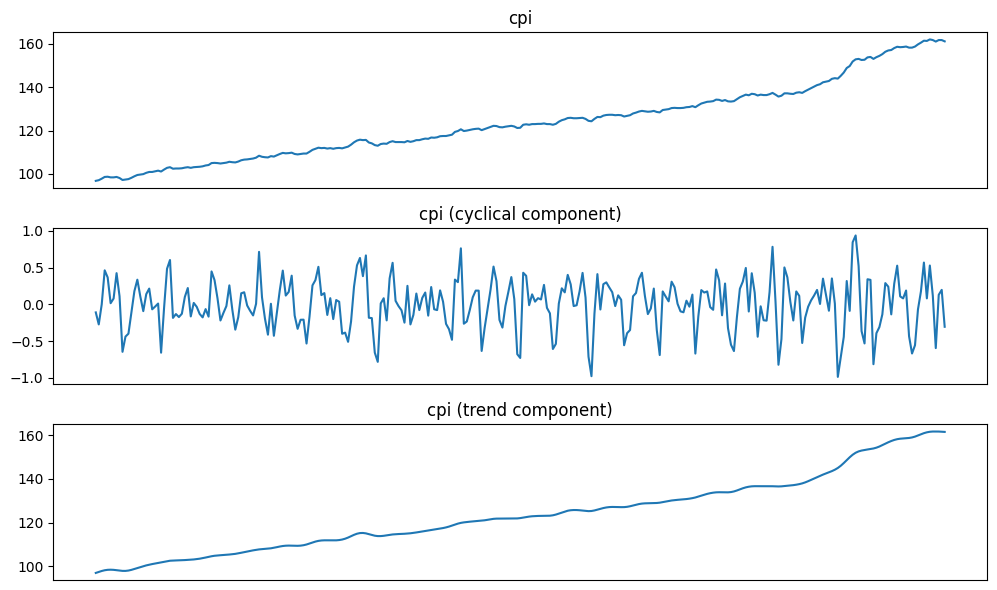

In [40]:
# plot cpi components
fig, axes = plt.subplots(3, 1, figsize=(10, 6))

axes[0].plot(data_diff.index, data_diff['cpi'])
axes[0].set_title('cpi')
axes[0].set_xticks([])

axes[1].plot(data_diff.index,
             data_diff['cpi_cyclical'])
axes[1].set_title('cpi (cyclical component)')
axes[1].set_xticks([])

axes[2].plot(data_diff.index,
             data_diff['cpi_trend'])
axes[2].set_title('cpi (trend component)')
axes[2].set_xticks([])

plt.tight_layout()
plt.show()


In [42]:
# convert index to datetime with frequncy for statsmodels
data_diff.index = pd.date_range(start = '2001-01-01',
                                periods = len(data_diff),
                                freq = 'MS')

## Statistical model of cpi - arima

The auto-regressive integrate moving average model is not a machine learning model, but a statistical model that is frequently used on time series data. It models series based upon its own prior values. The model accepts parameters p (AR component, relationship between the observation and previous observations), d (Integrated component, number of differences needed to make the time series stationary), and q (MA component, accounts for the error term as a linear combination of previous error terms). I iterated through various combinations of the p-d-q parameters to find the best fit.

In [43]:
def evaluate_arima_rmse(data, p_values, d_values, q_values):
    '''
    iterate through (p, d, q) values, fit ARIMA models, compute rmse

    parameters:
        data (pd.Series): ime series
        p_values (list): list of AR terms
        d_values (list): list of differencing terms
        q_values (list): list of MA terms

    Returns:
        results (list of tuples): (p, d, q, rmse)
    '''
    best_score = float('inf')
    results = []

    # iterate combinations of p-d-q
    for p, d, q in itertools.product(p_values,
                                     d_values,
                                     q_values):
        try:
            # fit
            model = ARIMA(data, order=(p, d, q))
            model_fit = model.fit()

            # prediction
            predictions = model_fit.fittedvalues

            # evaluate
            rmse = np.sqrt(mean_squared_error(data[d:],
                                              predictions[d:]))


            # results
            results.append((p, d, q, rmse))

            # best model
            if rmse < best_score:
                best_score = rmse
                best_cfg = (p, d, q)

            print(f'arima({p},{d},{q}) - rmse: {rmse:.4f}')

        except Exception as e:
            print(f'arima({p},{d},{q}) failed: {e}')
            continue

    # results to df
    results_df = pd.DataFrame(results, columns=['p', 'd', 'q', 'RMSE']).sort_values(by='RMSE')

    print('\nbest model:', best_cfg, 'with rmse:, best_score')

    return results_df

In [44]:
# train & test data - cyclical
train_arima_cyclical = data_diff['2001-01-01':'2023-12-31']['cpi_cyclical']
test_arima_cyclical = data_diff['2024-01-01':'2024-12-31']['cpi_cyclical']

In [45]:
warnings.filterwarnings('ignore', message = 'Non-stationary starting autoregressive parameters')
warnings.filterwarnings('ignore', message = 'Non-invertible starting MA parameters found.')
warnings.filterwarnings('ignore', message = 'Maximum Likelihood optimization failed to ')

# parameters to search
p_values = [1, 2, 3, 6, 12]
d_values = [0, 1]
q_values = [1, 2, 3, 6, 12]
df = train_arima_cyclical

arima_results = evaluate_arima_rmse(df,
                                    p_values,
                                    d_values,
                                    q_values)

arima(1,0,1) - rmse: 0.3007
arima(1,0,2) - rmse: 0.2692
arima(1,0,3) - rmse: 0.2619
arima(1,0,6) - rmse: 0.2606
arima(1,0,12) - rmse: 0.2315
arima(1,1,1) - rmse: 0.3145
arima(1,1,2) - rmse: 0.3035
arima(1,1,3) - rmse: 0.2974
arima(1,1,6) - rmse: 0.2626
arima(1,1,12) - rmse: 0.2425
arima(2,0,1) - rmse: 0.2549
arima(2,0,2) - rmse: 0.2330
arima(2,0,3) - rmse: 0.2690
arima(2,0,6) - rmse: 0.2598
arima(2,0,12) - rmse: 0.2343
arima(2,1,1) - rmse: 0.2979
arima(2,1,2) - rmse: 0.2599
arima(2,1,3) - rmse: 0.2974
arima(2,1,6) - rmse: 0.2673
arima(2,1,12) - rmse: 0.2378
arima(3,0,1) - rmse: 0.2548
arima(3,0,2) - rmse: 0.2525
arima(3,0,3) - rmse: 0.2586
arima(3,0,6) - rmse: 0.2598
arima(3,0,12) - rmse: 0.2343
arima(3,1,1) - rmse: 0.2974
arima(3,1,2) - rmse: 0.2934
arima(3,1,3) - rmse: 0.2610
arima(3,1,6) - rmse: 0.2943
arima(3,1,12) - rmse: 0.2338
arima(6,0,1) - rmse: 0.2401
arima(6,0,2) - rmse: 0.2394
arima(6,0,3) - rmse: 0.2448
arima(6,0,6) - rmse: 0.2315
arima(6,0,12) - rmse: 0.2280
arima(6,1,1) 

In [46]:
# model
arima_model = sm.tsa.ARIMA(train_arima_cyclical,
                           order = (12, 1, 12))

# fit
arima_fit = arima_model.fit()

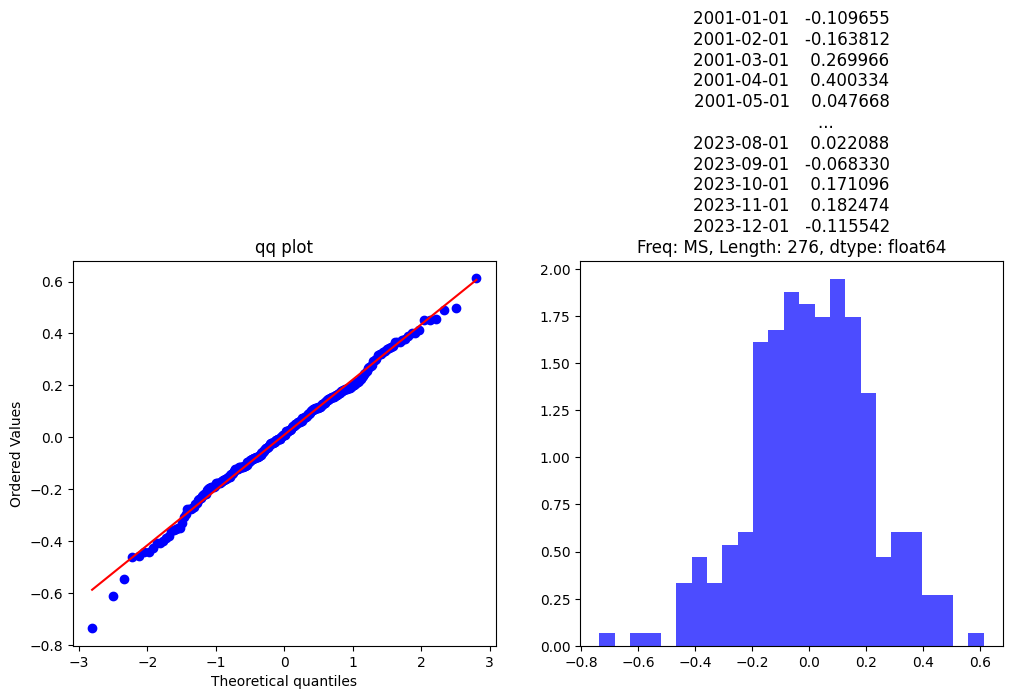

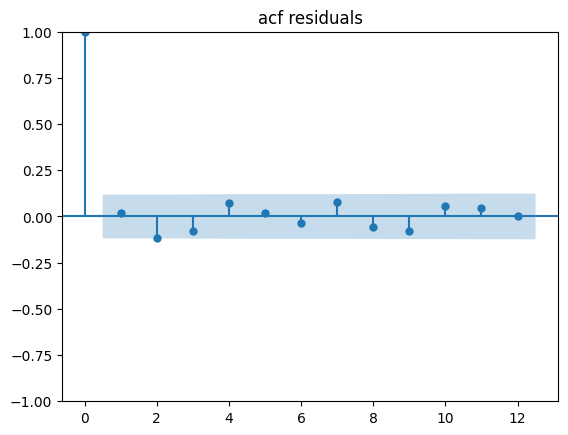

In [47]:
# residuals
residuals = arima_fit.resid

# plot hist and qq
fig, ax = plt.subplots(1,
                       2,
                       figsize = (12, 5))

stats.probplot(residuals,
               plot = ax[0])
ax[0].set_title('qq plot')

ax[1].hist(residuals,
           bins = 25,
           density = True,
           alpha = 0.7,
           color = 'blue')
ax[1].set_title(residuals)

plt.show()

# acf plot
sm.graphics.tsa.plot_acf(residuals,
                         lags = 12)
plt.title('acf residuals')
plt.show()

QQ plot doesn't look too bad, thought there is a group of outliers at the lower tail. Distribution or residuals looks relatively normal, and no acf in residuals. I think it's close enough for demonstrative purposes.

rmse: 0.2744949747221301
mae: 0.2143919784658917


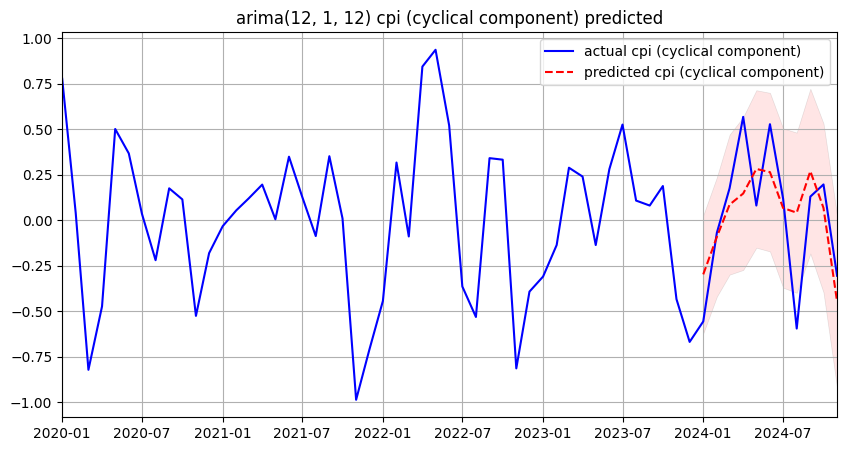

In [48]:
# pred on test data
forecast_test = arima_fit.get_forecast(steps = len(test_arima_cyclical))
predictions = forecast_test.predicted_mean
conf_int = forecast_test.conf_int(alpha = 0.10)

# evaluate
rmse = np.sqrt(mean_squared_error(test_arima_cyclical,
                                  predictions))
mae = mean_absolute_error(test_arima_cyclical,
                          predictions)

print(f'rmse: {rmse}')
print(f'mae: {mae}')

# plot
plt.figure(figsize=(10, 5))
plt.plot(data_diff.index,
         data_diff['cpi_cyclical'],
         label = 'actual cpi (cyclical component)',
         color = 'blue')
plt.plot(test_arima_cyclical.index,
         predictions,
         label = 'predicted cpi (cyclical component)',
         color = 'red',
         linestyle = 'dashed')
plt.fill_between(test_arima_cyclical.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color = 'red',
                 alpha = 0.10,
                 edgecolor = 'black',
                 linewidth = 0.5)
plt.legend()
plt.title('arima(12, 1, 12) cpi (cyclical component) predicted')
plt.xlim(pd.to_datetime('2020-01-01'), data_diff.index[-1])
plt.grid(True)

plt.show()

We can see that the arima model is picking up the general pattern of the cpi series. Now that I have a model, lets use it to forcast cpi for the next 6 months, just for funsies.

                 date  cpi_cyclical_forecast
2024-01-01 2024-12-01              -0.297613
2024-02-01 2025-01-01              -0.091833
2024-03-01 2025-02-01               0.085860
2024-04-01 2025-03-01               0.146981
2024-05-01 2025-04-01               0.282215
2024-06-01 2025-05-01               0.264676


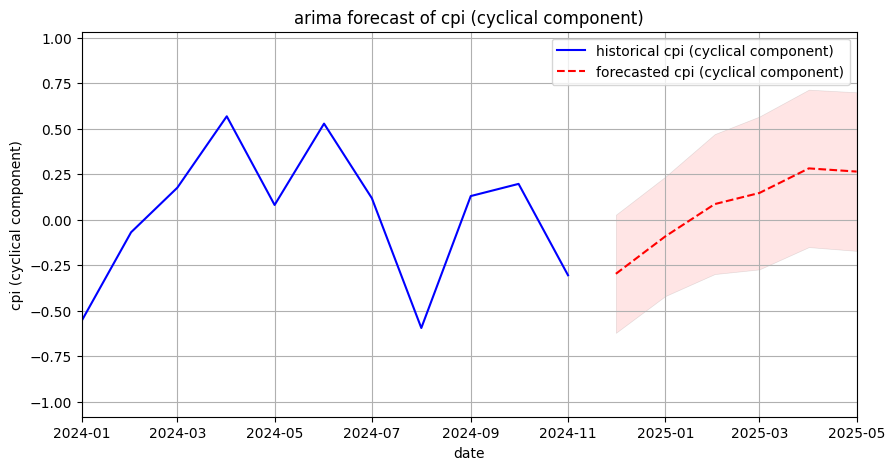

In [49]:
# last date
last_date = data_diff.index[-1]

# create future dates
future_dates = pd.date_range(start = last_date + pd.DateOffset(months = 1),
                             periods = 6,
                             freq = 'MS')


# forecast
forecast_future = arima_fit.get_forecast(steps = 6)
predictions_future = forecast_future.predicted_mean
conf_int_future = forecast_future.conf_int(alpha = 0.10)

forecast_df = pd.DataFrame({'date': future_dates,
                            'cpi_cyclical_forecast': predictions_future})

print(forecast_df)

# plot
plt.figure(figsize=(10, 5))

plt.plot(data_diff.index,
         data_diff['cpi_cyclical'],
         label = 'historical cpi (cyclical component)',
         color = 'blue')

plt.plot(forecast_df['date'],
         forecast_df['cpi_cyclical_forecast'],
         label = 'forecasted cpi (cyclical component)',
         color = 'red',
         linestyle = 'dashed')


plt.fill_between(forecast_df['date'],
                  conf_int_future.iloc[:, 0],
                  conf_int_future.iloc[:, 1],
                  color='red',
                  alpha=0.10,
                  edgecolor='black',
                  linewidth=0.5)

plt.legend()
plt.title('arima forecast of cpi (cyclical component)')
plt.xlabel('date')
plt.ylabel('cpi (cyclical component)')
plt.grid(True)

plt.xlim(pd.to_datetime('2024-01-01'), forecast_df['date'].max())

plt.show()

Now that I have a better of understanding of time series data, I'll move on to some machine learning.

## Machine learning

### Feature engineering

In [50]:
ml_df = data.copy()
ml_df = ml_df.reset_index()

In [51]:
ml_df.head()

,date,wage,rmpi,cpi,rate,announcement
0,2001-01,657.14,65.2,96.3,5.75,1.0
1,2001-02,653.59,65.8,96.8,5.75,0.0
2,2001-03,655.14,65.5,97.1,5.25,1.0
3,2001-04,652.44,65.2,97.8,5.00,1.0
4,2001-05,652.28,65.3,98.6,4.75,1.0


#### Target feature

In [52]:
# categorical target - rate_change
ml_df['rate_diff'] = ml_df['rate'].diff().fillna(0)
ml_df['rate_change'] = ml_df['rate_diff'].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))

In [53]:
ml_df['rate_change'].unique()

array([ 0, -1,  1])

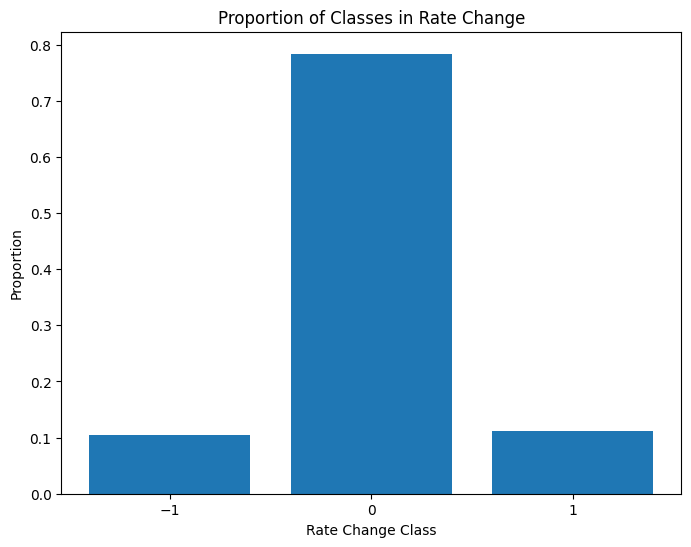

In [54]:
# plot class proportions
rate_change_counts = ml_df['rate_change'].value_counts()
proportions = rate_change_counts / len(ml_df)

plt.figure(figsize=(8, 6))
plt.bar(proportions.index, proportions.values)
plt.xlabel("Rate Change Class")
plt.ylabel("Proportion")
plt.title("Proportion of Classes in Rate Change")
plt.xticks(proportions.index)
plt.show()


Very imbalanced classes. I need to deal with this when modelling to prevent a biased model. If given 3 classes that were balanced and a person were to randomly guess at each class, we could expect that they would be correct 33.3% of the time; I'll use that as a baseline against which I can compare ml models.

#### X features

In [55]:
ml_df['date'] = pd.to_datetime(ml_df['date'])

In [56]:
# date features
ml_df['year'] = ml_df['date'].dt.year
ml_df['month'] = ml_df['date'].dt.month
ml_df['quarter'] = ml_df['date'].dt.quarter

In [57]:
# cpi lag features - months
ml_df['cpi_lag3'] = ml_df['cpi'].shift(3)
ml_df['cpi_lag6'] = ml_df['cpi'].shift(6)
ml_df['cpi_lag9'] = ml_df['cpi'].shift(9)
ml_df['cpi_lag12'] = ml_df['cpi'].shift(12)

In [58]:
# cpi rolling window - mean
ml_df['cpi_rolling_mean3'] = ml_df['cpi'].rolling(window = 3).mean()
ml_df['cpi_rolling_mean6'] = ml_df['cpi'].rolling(window = 6).mean()
ml_df['cpi_rolling_mean9'] = ml_df['cpi'].rolling(window = 9).mean()

In [59]:
# cpi exp. moving avg - ema
ml_df['cpi_ema3'] = ml_df['cpi'].ewm(span = 3).mean()
ml_df['cpi_ema6'] = ml_df['cpi'].ewm(span = 6).mean()
ml_df['cpi_ema9'] = ml_df['cpi'].ewm(span = 9).mean()

In [60]:
# cpi rate of change
ml_df['cpi_pct_change3'] = ml_df['cpi'].pct_change(periods = 3)
ml_df['cpi_pct_change6'] = ml_df['cpi'].pct_change(periods = 6)
ml_df['cpi_pct_change9'] = ml_df['cpi'].pct_change(periods = 9)
ml_df['cpi_pct_change12'] = ml_df['cpi'].pct_change(periods = 12) # year over year change.

<ipython-input-60-c86a68abc264>:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ml_df['cpi_pct_change3'] = ml_df['cpi'].pct_change(periods = 3)
<ipython-input-60-c86a68abc264>:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ml_df['cpi_pct_change6'] = ml_df['cpi'].pct_change(periods = 6)
<ipython-input-60-c86a68abc264>:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ml_df['cpi_pct_change9'] = ml_df

In [61]:
# cpi volatility
ml_df['cpi_rolling_std3'] = ml_df['cpi'].rolling(window = 3).std()
ml_df['cpi_rolling_std6'] = ml_df['cpi'].rolling(window = 6).std()

In [62]:
ml_df['cpi_diff_rolling_mean3'] = ml_df['cpi'] - ml_df['cpi_rolling_mean3']
ml_df['cpi_diff_rolling_mean6'] = ml_df['cpi'] - ml_df['cpi_rolling_mean6']

In [63]:
# inflation deviation
ml_df['inflation_dev'] = ml_df['cpi_pct_change12'] - 2
ml_df['inflation_dev_lag3'] = ml_df['inflation_dev'].shift(3)
ml_df['inflation_dev_lag6'] = ml_df['inflation_dev'].shift(6)
ml_df['inflation_dev_lag9'] = ml_df['inflation_dev'].shift(9)

In [64]:
# inflation trend - stabilizing or worsening?
ml_df['inflation_trend'] = ml_df['inflation_dev'].diff()
ml_df['inflation_trend_lag3'] = ml_df['inflation_trend'].shift(3)
ml_df['inflation_trend_lag6'] = ml_df['inflation_trend'].shift(6)
ml_df['inflation_trend_lag9'] = ml_df['inflation_trend'].shift(9)

In [65]:
# rmpi features
ml_df['rmpi_lag3'] = ml_df['rmpi'].shift(3)
ml_df['rmpi_lag6'] = ml_df['rmpi'].shift(6)
ml_df['rmpi_lag9'] = ml_df['rmpi'].shift(9)
ml_df['rmpi_lag12'] = ml_df['rmpi'].shift(12)

ml_df['rmpi_pct_change3'] = ml_df['rmpi'].pct_change(periods = 3)
ml_df['rmpi_pct_change6'] = ml_df['rmpi'].pct_change(periods = 6)
ml_df['rmpi_pct_change9'] = ml_df['rmpi'].pct_change(periods = 9)
ml_df['rmpi_pct_change12'] = ml_df['rmpi'].pct_change(periods = 12)

<ipython-input-65-180f2c2c622e>:7: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ml_df['rmpi_pct_change3'] = ml_df['rmpi'].pct_change(periods = 3)
<ipython-input-65-180f2c2c622e>:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ml_df['rmpi_pct_change6'] = ml_df['rmpi'].pct_change(periods = 6)
<ipython-input-65-180f2c2c622e>:9: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ml_df['rmpi_pct_change9'] = 

In [66]:
# wage features
ml_df['wage_lag3'] = ml_df['wage'].shift(3)
ml_df['wage_lag6'] = ml_df['wage'].shift(6)
ml_df['wage_lag9'] = ml_df['wage'].shift(9)
ml_df['wage_lag12'] = ml_df['wage'].shift(12)

ml_df['wage_pct_change3'] = ml_df['wage'].pct_change(periods = 3)
ml_df['wage_pct_change6'] = ml_df['wage'].pct_change(periods = 6)
ml_df['wage_pct_change9'] = ml_df['wage'].pct_change(periods = 9)
ml_df['wage_pct_change12'] = ml_df['wage'].pct_change(periods = 12)

<ipython-input-66-3d5c30f40828>:7: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ml_df['wage_pct_change3'] = ml_df['wage'].pct_change(periods = 3)
<ipython-input-66-3d5c30f40828>:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ml_df['wage_pct_change6'] = ml_df['wage'].pct_change(periods = 6)
<ipython-input-66-3d5c30f40828>:9: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ml_df['wage_pct_change9'] = 

In [67]:
# rate difference lag
ml_df['rate_diff_lag3'] = ml_df['rate_diff'].shift(3)
ml_df['rate_diff_lag6'] = ml_df['rate_diff'].shift(6)
ml_df['rate_diff_lag9'] = ml_df['rate_diff'].shift(9)

In [68]:
ml_df.dropna(inplace = True)

In [69]:
ml_df.columns

Index(['date', 'wage', 'rmpi', 'cpi', 'rate', 'announcement', 'rate_diff',
       'rate_change', 'year', 'month', 'quarter', 'cpi_lag3', 'cpi_lag6',
       'cpi_lag9', 'cpi_lag12', 'cpi_rolling_mean3', 'cpi_rolling_mean6',
       'cpi_rolling_mean9', 'cpi_ema3', 'cpi_ema6', 'cpi_ema9',
       'cpi_pct_change3', 'cpi_pct_change6', 'cpi_pct_change9',
       'cpi_pct_change12', 'cpi_rolling_std3', 'cpi_rolling_std6',
       'cpi_diff_rolling_mean3', 'cpi_diff_rolling_mean6', 'inflation_dev',
       'inflation_dev_lag3', 'inflation_dev_lag6', 'inflation_dev_lag9',
       'inflation_trend', 'inflation_trend_lag3', 'inflation_trend_lag6',
       'inflation_trend_lag9', 'rmpi_lag3', 'rmpi_lag6', 'rmpi_lag9',
       'rmpi_lag12', 'rmpi_pct_change3', 'rmpi_pct_change6',
       'rmpi_pct_change9', 'rmpi_pct_change12', 'wage_lag3', 'wage_lag6',
       'wage_lag9', 'wage_lag12', 'wage_pct_change3', 'wage_pct_change6',
       'wage_pct_change9', 'wage_pct_change12', 'rate_diff_lag3',
       'rate_d

Now that I have created features, I need to drop the rows where there was no rate change.

In [70]:
ml_df = ml_df[ml_df['announcement'] != 0]
ml_df = ml_df.drop(columns = ['announcement'])

### Feature selection

##### Feature/target correlation

To select features, I first found the correlation between each feature and the target. I started by cutting the features with the lowest correlation, until there were only 10 features remaining.

In [71]:
features = [
            #'wage', #current
            #'rmpi', #current
            #'cpi', #current
            #'rate', #current
            #'rate_diff', #current
            #'rate_change', #target
            #'year', #low corr
            #'month', #low corr
            #'quarter', #low corr
            #'cpi_lag3', #low corr
            #'cpi_lag6', #low corr
            #'cpi_lag9', #low corr
            #'cpi_lag12', #low corr
            #'cpi_rolling_mean3', #low corr
            #'cpi_rolling_mean6', #low corr
            #'cpi_rolling_mean9', low corr
            #'cpi_ema3', #low corr
            #'cpi_ema6', #low corr
            #'cpi_ema9', #low corr
            'cpi_pct_change3',
            'cpi_pct_change6',
            'cpi_pct_change9',
            'cpi_pct_change12',
            #'cpi_rolling_std3',
            'cpi_rolling_std6',
            'cpi_diff_rolling_mean3',
            'cpi_diff_rolling_mean6',
            #'inflation_dev', #current
            'inflation_dev_lag3',
            #'inflation_dev_lag6',
            #'inflation_dev_lag9', #low corr
            #'inflation_trend', #low corr
            #'inflation_trend_lag3', #low corr
            #'inflation_trend_lag6', #low corr
            #'inflation_trend_lag9', #low corr
            #'rmpi_lag3', low corr
            #'rmpi_lag6', #low corr
            #'rmpi_lag9', low corr
            'rmpi_pct_change3',
            'rmpi_pct_change6',
            'rmpi_pct_change9',
            'rmpi_pct_change12',
            'wage_lag3',
            'wage_lag6',
            'wage_lag9',
            'wage_lag12',
            'wage_pct_change3',
            'wage_pct_change6',
            'wage_pct_change9',
            'wage_pct_change12',
            'rate_diff_lag3',
            'rate_diff_lag6',
            #'rate_diff_lag9' #low corr
            ]

In [72]:
# replace infinite values with nan from pct change feature creation
for feature in features:
    ml_df[feature] = ml_df[feature].replace([np.inf, -np.inf], np.nan)
    ml_df[feature] = ml_df[feature].fillna(ml_df[feature].mean())

In [73]:
# corr
correlations = {feature: pointbiserialr(ml_df[feature],
                                        ml_df['rate_change'])[0] for feature in features}

corr_df = pd.DataFrame.from_dict(correlations,
                                 orient = 'index',
                                 columns = ['correlation'])

corr_df = corr_df.abs().sort_values(by = 'correlation',
                                    ascending = False)

print('number of total features: ', corr_df.shape[0])
corr_df.head(10)

number of total features:  22


,correlation
cpi_pct_change9,0.429643
cpi_pct_change12,0.390208
rate_diff_lag3,0.378094
cpi_pct_change6,0.364432
cpi_diff_rolling_mean6,0.299307
inflation_dev_lag3,0.290837
rmpi_pct_change12,0.288871
rmpi_pct_change9,0.271680
rate_diff_lag6,0.237986
cpi_diff_rolling_mean3,0.230108


In [74]:
top_features = corr_df.index.tolist()
top_features

['cpi_pct_change9',
 'cpi_pct_change12',
 'rate_diff_lag3',
 'cpi_pct_change6',
 'cpi_diff_rolling_mean6',
 'inflation_dev_lag3',
 'rmpi_pct_change12',
 'rmpi_pct_change9',
 'rate_diff_lag6',
 'cpi_diff_rolling_mean3',
 'cpi_pct_change3',
 'cpi_rolling_std6',
 'rmpi_pct_change6',
 'rmpi_pct_change3',
 'wage_lag9',
 'wage_lag6',
 'wage_lag3',
 'wage_lag12',
 'wage_pct_change12',
 'wage_pct_change9',
 'wage_pct_change6',
 'wage_pct_change3']

In [75]:
ml_df_top = ml_df[['date'] + top_features + ['rate_change']]

In [76]:
ml_df_top.columns

Index(['date', 'cpi_pct_change9', 'cpi_pct_change12', 'rate_diff_lag3',
       'cpi_pct_change6', 'cpi_diff_rolling_mean6', 'inflation_dev_lag3',
       'rmpi_pct_change12', 'rmpi_pct_change9', 'rate_diff_lag6',
       'cpi_diff_rolling_mean3', 'cpi_pct_change3', 'cpi_rolling_std6',
       'rmpi_pct_change6', 'rmpi_pct_change3', 'wage_lag9', 'wage_lag6',
       'wage_lag3', 'wage_lag12', 'wage_pct_change12', 'wage_pct_change9',
       'wage_pct_change6', 'wage_pct_change3', 'rate_change'],
      dtype='object')

#### Feature cross correlation

For the next step in feature selection, I found the cross-correlation between each of the features in order to identify potential multicollinearity. I sorted the top features alphabetically so they'd group together, making some patterns more apparent.

In [77]:
def create_heatmap(features):
     # cross correlation
     corr_matrix = ml_df_top[features].corr().abs()

     sorted_cols = sorted(corr_matrix.columns)
     corr_matrix = corr_matrix[sorted_cols]
     corr_matrix = corr_matrix.loc[sorted_cols]

     # plot
     plt.figure(figsize=(12, 10))
     sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
     plt.title('Correlation Plot of Top Features')
     plt.show()

In [78]:
# copied from above
top_features = ['cpi_pct_change9',
                #'cpi_pct_change12',
                'rate_diff_lag3',
                #'cpi_pct_change6',
                #'cpi_diff_rolling_mean6',
                'inflation_dev_lag3',
                'rate_diff_lag6',
                #'cpi_diff_rolling_mean3',
                'cpi_pct_change3',
                #'cpi_rolling_std6' #multicollinearity, lower corr
                ]

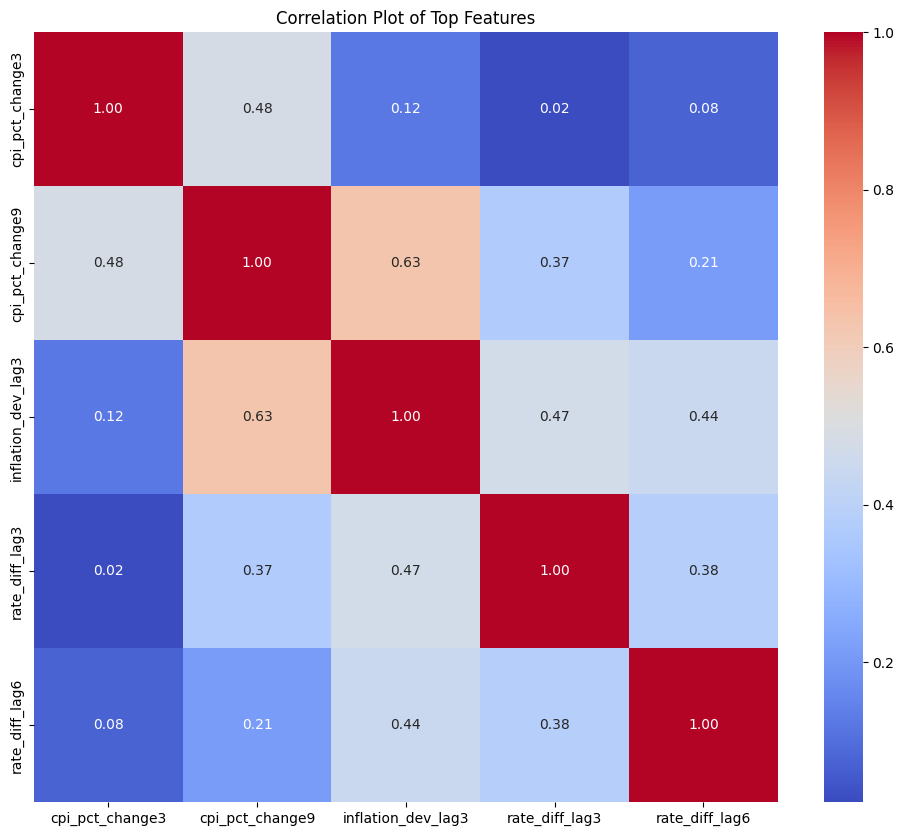

In [79]:
# plot heat map
create_heatmap(top_features)

In [80]:
ml_df_top = ml_df_top.loc[:, ['date'] + top_features + ['rate_change']]

### Model selection

In [81]:
# timeseries split
tscv = TimeSeriesSplit(n_splits = 5)

In [82]:
# features, target
X = ml_df_top[top_features]
y = ml_df_top['rate_change']

# models to try
models = {'logistic regression': LogisticRegression(multi_class = 'multinomial',
                                                         solver = 'lbfgs',
                                                         max_iter = 1000,
                                                         class_weight = 'balanced'),
          'random forest': RandomForestClassifier(n_estimators = 10,
                                                  class_weight = 'balanced',
                                                  random_state = 5506),
          'xg boost': XGBClassifier(use_label_encoder = False,
                             eval_metric = 'mlogloss'),
          'cat boost': CatBoostClassifier(verbose = 0)}

In [84]:
# store results
cv_results = {}

# loop through cv folds
for train_index, test_index in tscv.split(X):

    # train test data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # smote for class imbalance
    smote = SMOTE(k_neighbors = min(5, y_train.value_counts().min() - 1),
                  random_state = 5506)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # labels encoded
    encoder = LabelEncoder()
    y_train_resampled = encoder.fit_transform(y_train_resampled)
    y_test = encoder.transform(y_test)

    # scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)

    # models
    for model_name, model in models.items():

        # fit
        model.fit(X_train_scaled, y_train_resampled)

        # pred
        y_pred = model.predict(X_test_scaled)

        # eval
        accuracy = accuracy_score(y_test, y_pred)

        # store results
        if model_name not in cv_results:
            cv_results[model_name] = []
        cv_results[model_name].append(accuracy)

# avg accuracy
for model_name, accuracies in cv_results.items():
    avg_accuracy = np.mean(accuracies)
    print(f'model: {model_name}, avg acccuracy: {avg_accuracy:.4f}')

# best model
best_model = max(cv_results,
                 key = lambda k: np.mean(cv_results[k]))
print(f'\nbest model: {best_model}, Average Accuracy: {np.mean(cv_results[best_model]):.4f}')

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/

model: logistic regression, avg acccuracy: 0.4621
model: random forest, avg acccuracy: 0.4828
model: xg boost, avg acccuracy: 0.5379
model: cat boost, avg acccuracy: 0.5310

best model: xg boost, Average Accuracy: 0.5379


Given the results above, XGBoost has the best initial performance

### Hyperparameter tuning

In [85]:
# outer and inner loops to avoid data leakage and overfitting.
outer_cv = TimeSeriesSplit(n_splits = 5)
inner_cv = TimeSeriesSplit(n_splits = 5)

# outer loop for model selection
for train_index, test_index in outer_cv.split(X):
    X_train_outer, X_test_outer = X.iloc[train_index], X.iloc[test_index]
    y_train_outer, y_test_outer = y.iloc[train_index], y.iloc[test_index]

    # inner loop for hyperparameter tuning
    for train_index_inner, val_index_inner in inner_cv.split(X_train_outer):
        X_train_inner, X_val_inner = X_train_outer.iloc[train_index_inner], X_train_outer.iloc[val_index_inner]
        y_train_inner, y_val_inner = y_train_outer.iloc[train_index_inner], y_train_outer.iloc[val_index_inner]

        # smote resampling inner training data
        smote = SMOTE(k_neighbors = min(5, y_train_inner.value_counts().min() - 1),
                      random_state = 5506)
        X_train_resampled_inner, y_train_resampled_inner = smote.fit_resample(X_train_inner, y_train_inner)

        # scale inner training data
        scaler = StandardScaler()
        X_train_scaled_inner = scaler.fit_transform(X_train_resampled_inner)
        X_val_scaled_inner = scaler.transform(X_val_inner)

        # hyperparameter grid
        param_grid = {
                      'learning_rate': [0.17, 0.18, 0.19],
                      'max_depth': [7, 8, 9],
                      'n_estimators': [95, 100, 105],
                      'subsample': [1.0],
                      'colsample_bytree': [0.79, 0.80,0.81],
                      }

        # init time series split
        tscv = TimeSeriesSplit(n_splits=5)

        # model
        xgb_model = XGBClassifier(use_label_encoder = False,
                                  eval_metric = 'mlogloss')

        # grid search
        grid_search = GridSearchCV(
        estimator = xgb_model,
        param_grid = param_grid,
        scoring = 'accuracy',
        cv = tscv,
        n_jobs = -1,
        )

        # fita
        grid_search.fit(X_train_scaled, y_train_resampled)

        # best hyperparameters, eval
        print('best hyperparameters:', grid_search.best_params_)
        print('best score:', grid_search.best_score_)

        # best model
        best_xgb_model = grid_search.best_estimator_

        # best model for predictions
        y_pred = best_xgb_model.predict(X_test_scaled)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/

best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.18, 'max_depth': 8, 'n_estimators': 100, 'subsample': 1.0}
best score: 0.7345454545454546


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:07:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureW

best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.18, 'max_depth': 8, 'n_estimators': 100, 'subsample': 1.0}
best score: 0.7345454545454546


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:07:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureW

best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.18, 'max_depth': 8, 'n_estimators': 100, 'subsample': 1.0}
best score: 0.7345454545454546


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:08:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureW

best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.18, 'max_depth': 8, 'n_estimators': 100, 'subsample': 1.0}
best score: 0.7345454545454546


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:08:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureW

best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.18, 'max_depth': 8, 'n_estimators': 100, 'subsample': 1.0}
best score: 0.7345454545454546


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:08:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureW

best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.18, 'max_depth': 8, 'n_estimators': 100, 'subsample': 1.0}
best score: 0.7345454545454546


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureW

best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.18, 'max_depth': 8, 'n_estimators': 100, 'subsample': 1.0}
best score: 0.7345454545454546


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureW

best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.18, 'max_depth': 8, 'n_estimators': 100, 'subsample': 1.0}
best score: 0.7345454545454546


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.18, 'max_depth': 8, 'n_estimators': 100, 'subsample': 1.0}
best score: 0.7345454545454546


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/

best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.18, 'max_depth': 8, 'n_estimators': 100, 'subsample': 1.0}
best score: 0.7345454545454546


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:10:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureW

best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.18, 'max_depth': 8, 'n_estimators': 100, 'subsample': 1.0}
best score: 0.7345454545454546


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:10:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureW

best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.18, 'max_depth': 8, 'n_estimators': 100, 'subsample': 1.0}
best score: 0.7345454545454546


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:10:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureW

best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.18, 'max_depth': 8, 'n_estimators': 100, 'subsample': 1.0}
best score: 0.7345454545454546


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:11:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureW

best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.18, 'max_depth': 8, 'n_estimators': 100, 'subsample': 1.0}
best score: 0.7345454545454546


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:11:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureW

best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.18, 'max_depth': 8, 'n_estimators': 100, 'subsample': 1.0}
best score: 0.7345454545454546


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:11:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureW

best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.18, 'max_depth': 8, 'n_estimators': 100, 'subsample': 1.0}
best score: 0.7345454545454546


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:12:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureW

best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.18, 'max_depth': 8, 'n_estimators': 100, 'subsample': 1.0}
best score: 0.7345454545454546


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:12:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.18, 'max_depth': 8, 'n_estimators': 100, 'subsample': 1.0}
best score: 0.7345454545454546


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/

best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.18, 'max_depth': 8, 'n_estimators': 100, 'subsample': 1.0}
best score: 0.7345454545454546


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:13:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureW

best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.18, 'max_depth': 8, 'n_estimators': 100, 'subsample': 1.0}
best score: 0.7345454545454546


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:13:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureW

best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.18, 'max_depth': 8, 'n_estimators': 100, 'subsample': 1.0}
best score: 0.7345454545454546


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:13:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureW

best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.18, 'max_depth': 8, 'n_estimators': 100, 'subsample': 1.0}
best score: 0.7345454545454546


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:14:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureW

best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.18, 'max_depth': 8, 'n_estimators': 100, 'subsample': 1.0}
best score: 0.7345454545454546


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:14:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureW

best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.18, 'max_depth': 8, 'n_estimators': 100, 'subsample': 1.0}
best score: 0.7345454545454546
best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.18, 'max_depth': 8, 'n_estimators': 100, 'subsample': 1.0}
best score: 0.7345454545454546


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:14:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [86]:
# evaluate best model
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Test Accuracy: {accuracy}")


XGBoost Test Accuracy: 0.3793103448275862


lol. That definitely is overfit to the training data, results are barely better than a baseline model with random chance.

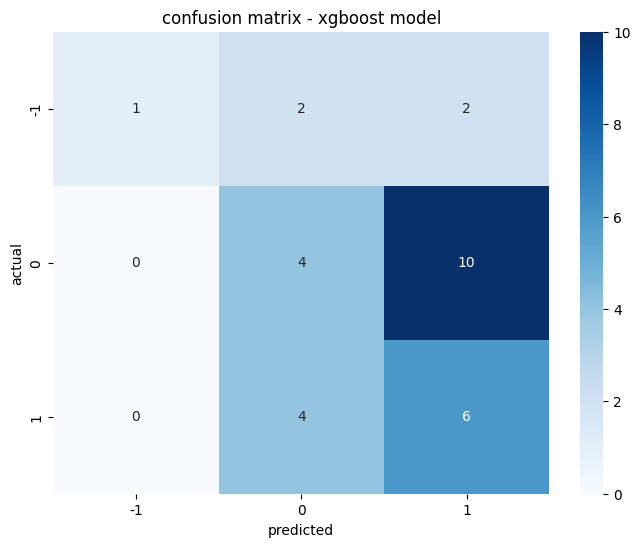

In [87]:
# confusion matriz
y_pred = best_xgb_model.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("predicted")
plt.ylabel("actual")
plt.title("confusion matrix - xgboost model")
plt.show()


RNN model

In [88]:
# reshape data for rnn (samples, timesteps, features)
timesteps = 1
X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], timesteps, X_train_scaled.shape[1]))
X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], timesteps, X_test_scaled.shape[1]))

# rnn model
model_rnn = Sequential()
model_rnn.add(Input(shape=(timesteps, X_train_scaled.shape[1])))
model_rnn.add(LSTM(50, activation = 'relu'))
model_rnn.add(Dense(3, activation = 'softmax'))

# compile
model_rnn.compile(optimizer = 'adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'])

# fit
model_rnn.fit(X_train_rnn,
              y_train_resampled,
              epochs = 100,
              verbose = 0)

# eval
loss, accuracy = model_rnn.evaluate(X_test_rnn,
                                    y_test,
                                    verbose = 0)

print(f'rnn accuracy: {accuracy:.4f}')

# pred
y_pred_rnn = model_rnn.predict(X_test_rnn).argmax(axis = 1)

# classification
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_rnn))


rnn accuracy: 0.4138
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.40      0.14      0.21        14
           2       0.38      0.80      0.52        10

    accuracy                           0.41        29
   macro avg       0.48      0.45      0.41        29
weighted avg       0.44      0.41      0.37        29



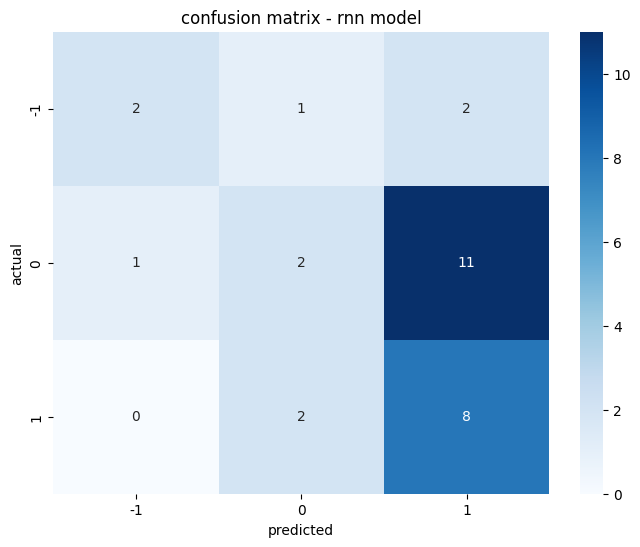

In [89]:
cm_rnn = confusion_matrix(y_test, y_pred_rnn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rnn, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("predicted")
plt.ylabel("actual")
plt.title("confusion matrix - rnn model")
plt.show()


## Discussion

Further study:
* Feature selection. None of the features had a very strong correlation with rate changes. It's not realistic to expect a model to perform well when there's not good data to work with. More series that could be added are:
  * housing market indicators
  * consumer and business confidence
  * exchange rate (import/export/commodity markets)
  * unemployment rate
  * gdp
  * A very large number of features could be engineered from these few series. Just as I modelled cpi, each one could be modelled with other predictors.

* More domain knowledge. While I have a background in economics, I didn't spend much time reading up on economic models for this project due to time constraints. The models created here would not be suitable for use in production.
* Turn feature engineering and selection process into a pipeline. This would be useful as more features are added.

## References

*   List item
*   List item

